In [1]:
# pip install git+https://github.com/facebookresearch/fvcore.git

%load_ext autoreload
%autoreload 2

import os
import sys

if not os.path.join(os.getcwd(), 'pycocotools') in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'pycocotools'))

import io

import detectron2

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

from loader.images import ImageS3

import numpy as np
import cv2
import torch

# Visualization

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
cfg = get_cfg()
cfg.merge_from_file('bua/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml')
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight

# curl https://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr_original.pkl --output bua/weights/faster_rcnn_from_caffe_attr_original.pkl
cfg.MODEL.WEIGHTS = 'bua/weights/faster_rcnn_from_caffe_attr_original.pkl'  # 'https://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr_original.pkl' 
# 'http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl'
if not torch.cuda.is_available():
    cfg.MODEL.DEVICE = 'cpu'

#cfg
predictor = DefaultPredictor(cfg)

Config 'bua/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



(480, 640, 3)


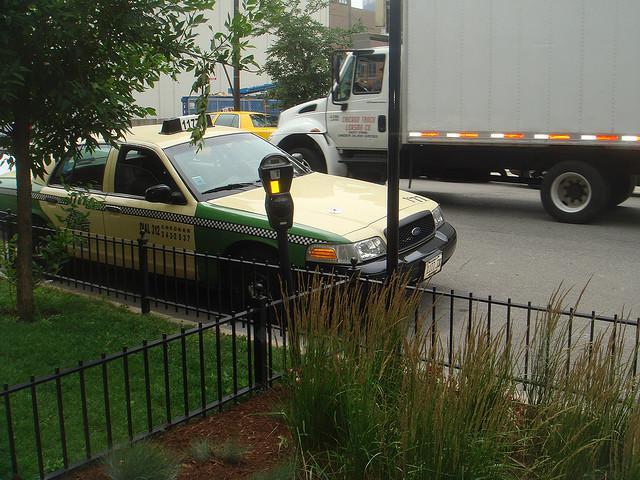

In [3]:
NUM_OBJECTS = 50

img_bucket = ImageS3()

img_file = 'coco/test/000000000001.jpg' # 'images/img.png'
img = img_bucket.getImageCV(img_file)
#img = cv2.imread(img_file)

print(img.shape)

im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showarray(im_rgb)


In [4]:
def extract_features(img):
    with torch.no_grad():
        raw_height, raw_width = img.shape[:2]

        image = predictor.transform_gen.get_transform(img).apply_image(img)
        print("Transformed image size: ", image.shape[:2])

        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)

        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)

        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)

        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)

        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )

        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]

        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)

        # NMS
        for nms_thresh in np.arange(0.5, 1.0, 0.1):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:], 
                score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break

        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        max_attr_prob = max_attr_prob[ids].detach()
        max_attr_label = max_attr_label[ids].detach()
        instances.attr_scores = max_attr_prob
        instances.attr_classes = max_attr_label
        
        return instances, roi_features


In [5]:
#NUM_OBJECTS = 50

#img_file = 'images/img.png'
#img = cv2.imread(img_file)

#print(img.shape)

#im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#showarray(im_rgb)

instances, features = extract_features(img)

Transformed image size:  (800, 1067)
Proposal Boxes size: torch.Size([138, 4])
Pooled features size: torch.Size([138, 2048])


/home/ec2-user/SageMaker/py-bottom-up-attention/detectron2/modeling/roi_heads/fast_rcnn.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [6]:
# Load VG Classes
data_path = 'bua/data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())
        
vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [11]:
#instances, features = extract_image(img)
print(type(features))
features

<class 'torch.Tensor'>


tensor([[3.6254e-01, 0.0000e+00, 1.8459e-01,  ..., 3.1241e+00, 2.4605e+00,
         4.4870e-01],
        [1.1069e-03, 3.8689e-01, 3.4005e+00,  ..., 6.2651e+00, 0.0000e+00,
         2.4236e+00],
        [5.6144e-01, 0.0000e+00, 1.3367e-02,  ..., 1.4356e-01, 1.7678e-01,
         2.6509e-01],
        ...,
        [2.5261e-02, 6.3299e-01, 2.9799e+00,  ..., 6.8350e+00, 8.7913e-01,
         5.5644e-01],
        [0.0000e+00, 5.1633e+00, 3.9946e+00,  ..., 1.4717e+00, 1.1402e-01,
         0.0000e+00],
        [0.0000e+00, 9.7985e-01, 3.0043e+00,  ..., 5.7074e+00, 4.5654e-01,
         1.7202e+00]])

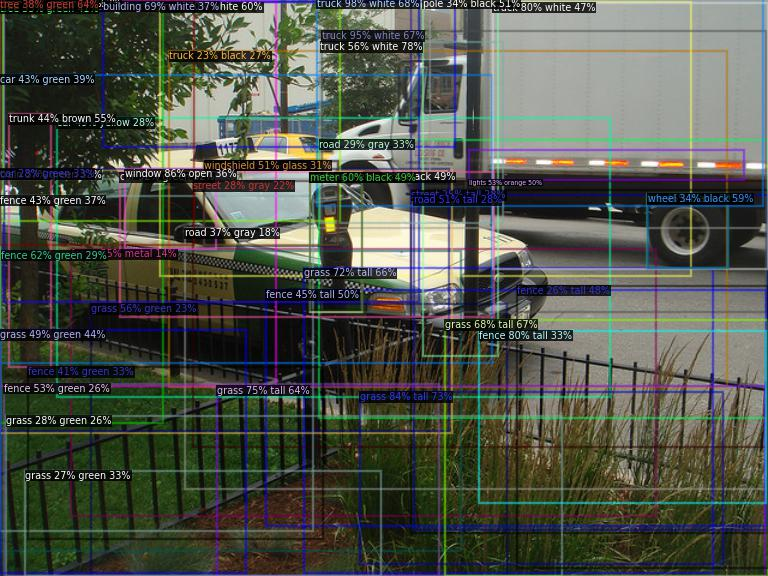

In [8]:
# Show the boxes, labels, and features
pred = instances.to('cpu')
v = Visualizer(img[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])